# Plots 

> Defines some circadian data science plots, like actograms

In [3]:
#| hide 
%load_ext autoreload
%autoreload 2

In [4]:
# | default_exp plots

In [5]:
# | hide
from nbdev.showdoc import *

In [6]:
# | export

from scipy.ndimage import gaussian_filter1d
from copy import deepcopy
import pylab as plt
import numpy as np
from pathlib import Path
import sys
from circadian.utils import cut_phases_12
from circadian.models import Hannay19
from circadian.lights import *


## Actograms



Actograms help display periodic trends in data.

::: {.callout-note}
I prefer my actograms to show low values as black and high values as white. The convention in circadian science (for some reason) is the reverse. This can easily be switched in plot calls if you want to do things the wrong way.
:::

In [7]:
# | export

class Actogram:
    """ 
        Create an Actogram visualisation of the data
    """

    def __init__(self,
                 time_total: np.ndarray, # time in hours
                 light_vals: np.ndarray, # light values or proxy should be the same length as time_total
                 second_zeit: np.ndarray = None, # optional second zeitgeber to show on the right side
                 ax=None, # Axis to plot on, if None a new figure is created
                 threshold=10.0, # threshold for light on/off 
                 threshold2=None, # threshold for light on/off for second zeitgeber
                 opacity: float = 1.0, # opacity of the light on/off rectangles
                 color: str = 'black', # color of the light on/off rectangles, for the below threshold values
                 smooth=True, # whether to apply a gaussian filter to the light values to smooth it, useful for wearable data
                 sigma=[2.0, 2.0], # sigma for the gaussian filter
                 *args, # additional plot arguments
                 **kwargs # additional plot keyword arguments
                 ):

        self.time_total = time_total
        self.light_vals = light_vals
        self.num_days = np.ceil((time_total[-1] - time_total[0])/24.0)

        self.second_zeit = second_zeit if second_zeit is not None else light_vals

        if smooth:
            self.light_vals = gaussian_filter1d(
                self.light_vals, sigma=sigma[0])
            self.second_zeit = gaussian_filter1d(
                self.second_zeit, sigma=sigma[1])

        threshold2 = threshold if threshold2 is None else threshold2
        self.ax = ax if ax is not None else plt.gca()

        # Set graphical parameters
        label_scale = int(np.floor(self.num_days/30))
        if label_scale < 1:
            label_scale = 1

        self.opacity = opacity
        self.darkColor = color
        start_day = np.floor(self.time_total[0]/24.0)
        self.ax.set_ylim(start_day, self.num_days+start_day)
        self.ax.set_xlim(0, 48)
        self.ax.set_yticks(
            np.arange(int(start_day), self.num_days+1+start_day, label_scale))
        ylabels_list = list(range(int(start_day), int(
            self.num_days+start_day)+1, label_scale))
        # ylabels_list.reverse()

        self.ax.set_yticklabels(ylabels_list)
        self.ax.set_xticks(np.arange(0, 48+3, 3))
        xlabels_list = list(range(0, 27, 3))+list(range(3, 27, 3))
        self.ax.set_xticklabels(xlabels_list)
        self.ax.set_xticks(np.arange(0, 48, 1), minor=True)

        #self.ax.yaxis.grid(False, linewidth=1.0, color='k')
        # self.ax.xaxis.grid(False)

        self.ax.plot(24.0*np.ones(100), 
                     np.linspace(0, self.num_days,100), 
                     ls='--', 
                     lw=2.0, 
                     color='black', 
                     zorder=9)
        self.ax.set_xlabel("ZT")
        self.ax.set_ylabel("Days")

        self.addLightSchedule(self.light_vals, threshold,
                              plt_option='left', color=self.darkColor)
        self.addLightSchedule(self.second_zeit, threshold2,
                              plt_option='right', color=self.darkColor)
        self.ax.invert_yaxis()

    def getRectangles(self, timeon, timeoff, colorIn='white'):
        bottom_x = np.fmod(timeon, 24.0)
        bottom_y = int(timeon/24.0)  # -1
        alpha = self.opacity if colorIn != 'white' else 0.0
        r1 = plt.Rectangle((bottom_x, bottom_y), timeoff -
                           timeon, 1, fc=colorIn, zorder=-1, alpha=alpha)
        r2 = plt.Rectangle((bottom_x+24.0, bottom_y),
                           timeoff-timeon, 1, fc=colorIn, zorder=1, alpha=alpha)
        return((r1, r2))

    def addRect(self, timeon, timeoff, colorIn='white', plt_option='both'):
        """Used to add a rectangle to the axes"""
        r = self.getRectangles(timeon, timeoff, colorIn)
        if plt_option == 'left':
            self.ax.add_patch(r[0])
            return
        if plt_option == 'right':
            self.ax.add_patch(r[1])
            return
        self.ax.add_patch(r[0])
        self.ax.add_patch(r[1])

    def addLightSchedule(self, zeit: np.ndarray,
                         threshold: float,
                         plt_option: str = 'both',
                         color='black'):
        lightdata = zeit
        timedata = self.time_total
        lightsOn = False
        if (lightdata[0] > threshold):
            lightsOn = True
            lightStart = timedata[0]
        else:
            darkOn = True
            darkStart = timedata[0]

        dayCounter = int(timedata[0]/24.0)  # count the days in the data set
        for i in range(1, len(lightdata)):
            currentDay = int(timedata[i]/24.0)
            if (currentDay != dayCounter):
                dayCounter = currentDay
                if (lightsOn == True):
                    self.addRect(
                        lightStart, timedata[i], plt_option=plt_option)
                    if (i+1 < len(timedata)):
                        # reset the light counter to start over the next day
                        lightStart = timedata[i+1]
                else:
                    self.addRect(
                        darkStart, timedata[i], colorIn=color, plt_option=plt_option)
                    if (i+1 < len(timedata)):
                        darkStart = timedata[i+1]

            if (lightdata[i] < threshold and lightsOn == True):
                self.addRect(lightStart, timedata[i-1], plt_option=plt_option)
                lightsOn = False
                darkOn = True
                darkStart = timedata[i]
            if (lightsOn == False and lightdata[i] >= threshold):
                lightsOn = True
                lightStart = timedata[i]
                darkOn = False
                self.addRect(
                    darkStart, timedata[i-1], colorIn=color, plt_option=plt_option)

    def plot_phasemarker(self, phase_marker_times: np.ndarray,
                         error: np.ndarray = None,
                         alpha=1.0,
                         alpha_error=0.30,
                         scatter=False,
                         *args, **kwargs):
        """
        This method takes in a list of times which are assumed to occur at the same 
        circadian phase (e.g. DLMO, CBTmin). These are plotted as points 
        on the actogram.  
            plot_phasemarker(self, phase_marker_times: np.ndarray, *args, **kwargs)
        """

        xvals = deepcopy(phase_marker_times)
        yvals = deepcopy(phase_marker_times)

        xvals = np.fmod(xvals, 24.0)
        yvals = np.floor(yvals / 24.0) + 0.5

        if scatter:
            self.ax.scatter(xvals, yvals, *args, **kwargs)
            self.ax.scatter(xvals+24.0, yvals, *args, **kwargs)

        idx_split = (np.absolute(np.diff(xvals)) > 6.0).nonzero()[0]+1
        xvals_split = np.split(xvals, idx_split)
        yvals_split = np.split(yvals, idx_split)
        if error is not None:
            error_split = np.split(error, idx_split)

        for (idx, xx) in enumerate(xvals_split):
            self.ax.plot(xx, yvals_split[idx], alpha=alpha, *args, **kwargs)
            self.ax.plot(
                xx+24.0, yvals_split[idx], alpha=alpha, *args, **kwargs)
            if error is not None:
                self.ax.fill_betweenx(
                    yvals_split[idx], xx-error_split[idx], xx+error_split[idx], alpha=alpha_error, *args, **kwargs)
                self.ax.fill_betweenx(
                    yvals_split[idx], xx-error_split[idx]+24.0, xx+error_split[idx]+24.0, alpha=alpha_error, *args, **kwargs)

    def plot_phasetimes(self, 
                        times: np.ndarray, 
                        phases: np.ndarray, 
                        error: np.ndarray = None,
                        alpha_error=0.30, 
                        alpha=1.0, 
                        *args, 
                        **kwargs):
        """
            This method takes observations of the phase and times (same length arrays)
            and adds them to the actogram.    

            plot_phasetimes(self, times: np.ndarray, phases: np.ndarray, *args, **kwargs)
        """
        xvals = deepcopy(phases)
        xvals = np.arctan2(np.sin(xvals), np.cos(xvals))
        for i in range(len(xvals)):
            if xvals[i] < 0.0:
                xvals[i] += 2*np.pi

        xvals = np.fmod(xvals, 2*np.pi)
        xvals *= 12.0/np.pi

        xvals = np.fmod(xvals, 24.0)
        yvals = deepcopy(times)
        yvals = np.floor(yvals / 24.0) + 0.5

        idx_split = (np.absolute(np.diff(xvals)) > 6.0).nonzero()[0]+1
        xvals_split = np.split(xvals, idx_split)
        yvals_split = np.split(yvals, idx_split)
        if error is not None:
            error_split = np.split(error, idx_split)

        for (idx, xx) in enumerate(xvals_split):
            self.ax.plot(xx, yvals_split[idx], alpha=alpha, *args, **kwargs)
            self.ax.plot(
                xx+24.0, yvals_split[idx], alpha=alpha, *args, **kwargs)
            if error is not None:
                self.ax.fill_betweenx(
                    yvals_split[idx], xx-error_split[idx], xx+error_split[idx], alpha=alpha_error, *args, **kwargs)
                self.ax.fill_betweenx(
                    yvals_split[idx], xx-error_split[idx]+24.0, xx+error_split[idx]+24.0, alpha=alpha_error, *args, **kwargs)



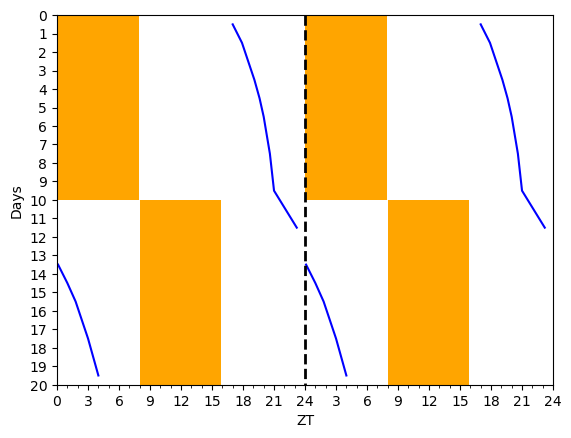

In [8]:
slam_shift = Light.SlamShift() 
ts = np.arange(0, 20*24.0, 0.10)
light_values = slam_shift(ts) 

act = Actogram(ts, light_vals=light_values, smooth=False)
spm = Hannay19()

trajectory = spm(ts, light_values, np.array([1.0, np.pi, 0.0]))
dlmo = spm.dlmos(trajectory=trajectory)

act.plot_phasemarker(dlmo, color='blue')
plt.show()


In [9]:
#| export 

def plot_mae(dlmo_actual: np.ndarray,  # expected to be in hours
             dlmo_pred: np.ndarray,  # predicted to be in hours
             norm_to: float = None, 
             ax=None,  
             *args, 
             **kwargs):

    dlmo_actual = np.fmod(dlmo_actual, 24.0)
    dlmo_pred = np.fmod(dlmo_pred, 24.0)

    # Make the plot range from from -12 to 12
    dlmo_pred = np.array([cut_phases_12(d) for d in list(dlmo_pred)])
    dlmo_actual = np.array([cut_phases_12(d) for d in list(dlmo_actual)])

    if norm_to is not None:
        dlmo_actual = dlmo_actual - np.mean(dlmo_actual)+norm_to

    if ax is None:
        plt.figure()
        ax = plt.gca()

    errors = dlmo_pred-dlmo_actual
    print(f"The MAE is: {np.mean(abs(errors))}")
    print(f"Within one hour {np.sum(abs(errors)<=1.0)}/{len(dlmo_pred)}")
    print(errors)

    ax.scatter(dlmo_actual, dlmo_pred, *args, **kwargs)
    ax.plot(np.arange(-12, 12, 1), np.arange(-12, 12, 1),
            ls='--', color='gray', lw=2.0)
    ax.plot(np.arange(-12, 12, 1), np.arange(-12, 12, 1)+1,
            ls='--', color='blue', lw=1.0)
    ax.plot(np.arange(-12, 12, 1), np.arange(-12, 12, 1)-1,
            ls='--', color='blue', lw=1.0)

    ax.set_ylabel("Model Prediction (hrs)")
    ax.set_xlabel("Experimental DLMO (hrs)")



The MAE is: 3.1496612118555647
Within one hour 11/30
[-21.82630248   1.96831962   0.52892396   1.35677969   2.28609226
  -2.41953651  -0.37226796   2.16414767  -0.98730589  -1.96956835
  -0.6137371    0.64040472  -0.87977285   1.05304478   2.8907449
   4.55204144  -2.28786898   2.06687537  -3.47517726   4.36211676
   0.9388304    1.71968311   0.33793934   0.24607724   1.43775429
   0.57839859  -1.59776186   0.78218773  -4.91788887 -23.23228635]


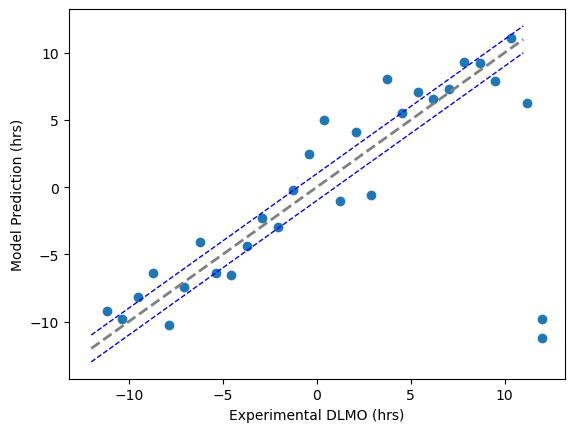

In [10]:

dlmo_experimental = np.linspace(-12, 12., 30) 
dlmo_predicted = dlmo_experimental + np.random.normal(0, 2, len(dlmo_experimental))

plot_mae(dlmo_experimental, dlmo_predicted)

In [11]:
 #| export
 
 
def plot_torus(phase1: np.ndarray, # array of phases  
               phase2: np.ndarray, #array of phases, assumed to be the same length as phase1
               scaled_by: float = None, # should the phases be wrapped, this just applies an fmod to the phases
               ax=None, # axis to plot on, if None, a new figure is created
               *args, # passed to the scatter plot
               **kwargs, # passed to the scatter plot
               ) -> plt.Axes:

    if ax is None:
        plt.figure()
        ax = plt.gca()

    if scaled_by is not None:
        phase1 = np.fmod(phase1, scaled_by) * np.pi/12.0
        phase2 = np.fmod(phase2,  scaled_by) * np.pi/24.0

    phase1 = np.arctan2(np.sin(phase1), np.cos(phase1))
    phase2 = np.arctan2(np.sin(phase2), np.cos(phase2))

    ax.scatter(phase1, phase2, *args, **kwargs)
    
    return ax


Here is an example of the torus plot, which allows one to visualize the relationsjip between two phases. 

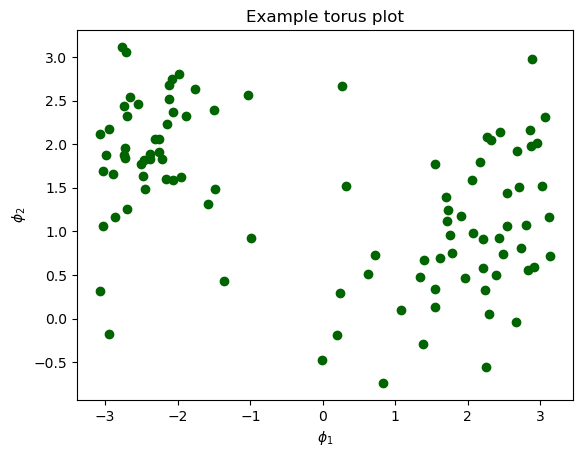

In [12]:
phi1 = 12.0 + 5.0*np.random.randn(100) 
phi2 = phi1 + 5.0*np.random.randn(100)

plot_torus(phi1, phi2, scaled_by=24.0, color='darkgreen')
plt.title("Example torus plot")
plt.xlabel("$\phi_1$") 
plt.ylabel("$\phi_2$");

Example of an actogram

In [13]:
# | export

class Stroboscopic:
    """
    This class can be used to make a stroboscopic plot of the entrainment of an oscillator to a sudden shift in schedule
    """

    def __init__(self, 
                 ax: plt.Axes, # The axes to plot on
                 ts: np.ndarray, # The time series of the model
                amplitude: np.ndarray, # The amplitude of the model, assumed to be the same length as ts
                phase: np.ndarray, # The phase of the model, assumed to be the same length as ts
                period: float = 24.0, # The time period between stroboscopic arrows
                *args: tuple, #passed to the quiver plot
                **kwargs: dict #passed to the quiver plot
        ):
        
        self.ts = ts
        self.R = amplitude
        self.phase = phase
        self.period = period
        self.ax = ax

        self._make_strobo_plot(*args, **kwargs)

    def _make_strobo_plot(self, *args, **kwargs):
        """Add the paths to a quiver plot"""
        start_amp = self.R[0]

        Xvals = np.array(self.R / start_amp * np.cos(self.phase))
        Yvals = np.array(self.R / start_amp * np.sin(self.phase))

        circle_angles = np.linspace(0, 2 * np.pi, 1000)
        circle_x = list([np.cos(x) for x in circle_angles])
        circle_y = list([np.sin(x) for x in circle_angles])

        self.ax.plot(circle_x, circle_y, lw=2.0, color='k')
        # Sample down to every 24 hours
        Xvals = np.interp(np.arange(self.ts[0], self.ts[-1], self.period), self.ts, Xvals)
        Yvals = np.interp(np.arange(self.ts[0], self.ts[-1], self.period), self.ts, Yvals)
        upper_bound = len(Xvals)
        for i in range(1, upper_bound):
            self.ax.quiver(Xvals[i - 1], Yvals[i - 1], Xvals[i] - Xvals[i - 1], Yvals[i] - Yvals[i - 1],
                           scale_units='xy', angles='xy', scale=1, *args, **kwargs)
        self.ax.set_xlim([-1.1, 1.1])
        self.ax.set_ylim([-1.1, 1.1])
        self.ax.scatter([0.0], [0.0], color='k')
        self.ax.set_axis_off()

    def add_strobo_plot(self, 
                        amplitude: np.ndarray,
                        phase: np.ndarray,
                        col='darkgreen'):
        """Add a strobo plot to the axes for comparison"""
        start_amp = amplitude[0]

        Xvals = np.array(amplitude / start_amp * np.cos(phase))
        Yvals = np.array(amplitude / start_amp * np.sin(phase))

        # Sample down to every 24 hours
        Xvals = Xvals[::240]
        Yvals = Yvals[::240]

        upper_bound = min(10, len(Xvals))
        for i in range(1, upper_bound + 10):
            self.ax.quiver(Xvals[i - 1], Yvals[i - 1], Xvals[i] - Xvals[i - 1], Yvals[i] - Yvals[i - 1],
                           scale_units='xy', angles='xy', scale=1, color=col)


This is how you can visualize entrainment using a Stroboscopic plot of a trajectory

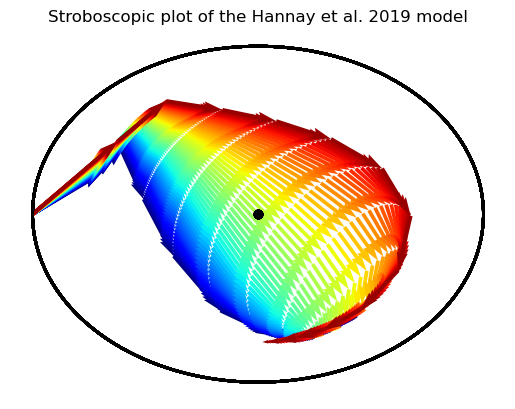

In [14]:

slam_shift = Light.SlamShift(shift=12.0, lux = 500.0, before_days = 2, after_days=30) 
ts = np.arange(0.0, 15*24.0, 0.10)
light_values = slam_shift(ts)
# Run this for a range of period parameters 
batch_dim = 50
hmodel = Hannay19({ 'tau': np.linspace(23.5,24.5,batch_dim) }) 

initial_state = np.array([1.0, np.pi, 0.0]) + np.zeros((batch_dim, 3))
trajectory = hmodel(ts=ts, light_est=light_values, state=initial_state)
ax = plt.gca()
cmap = plt.get_cmap('jet')
for idx in range(trajectory.batch_size):
    Stroboscopic(ax, 
                ts, 
                trajectory.states[idx, 0, :], 
                trajectory.states[idx, 1, :], 
                period=24.0, 
                lw=0.50,
                color=cmap(idx/batch_dim));
plt.title("Stroboscopic plot of the Hannay et al. 2019 model");


In [22]:
import matplotlib as mpl
viridis = mpl.colormaps['jet']

viridis(1.2)

(0.5, 0.0, 0.0, 1.0)

In [180]:

def plot_actogram(ax: plt.Axes, # plot axes
                  zeitgeber: np.ndarray, # the zeitgeber to display
                  num_day: int = 240, # number of points per day
                  cmap: mpl.colors.Colormap = mpl.cm.get_cmap('jet'), # the colormap to use
                  label_days: int = 7, # the number of days between labels
                  *args, # passed to imshow
                  **kwargs # passed to imshow
                 ) -> plt.Axes:
    
    """Make an actogram plot with color"""
    zeitgeber = np.flip(zeitgeber)
    whole_days = zeitgeber.shape[0] // num_day 
    zeitgeber = zeitgeber[:whole_days*num_day]
    X = zeitgeber.reshape(-1, num_day)
    total_days = X.shape[0]
    ax.imshow(X, 
              cmap=cmap, 
              extent=[0, num_day, 0, total_days], 
              aspect=num_day/total_days, *args, **kwargs)
    
    start_day = 0
    ax.set_ylim(0, total_days+start_day)
    ax.set_xlim(0, num_day)
    ax.set_yticks(
        np.arange(int(start_day), total_days+1+start_day, label_days))
    ylabels_list = list(range(int(start_day), int(
        total_days+start_day)+1, label_days))
    ax.set_yticklabels(ylabels_list)
    
    ax.set_xticks(np.arange(0, 240, 30))
    xlabels_list = list(range(0, 24, 3))
    ax.set_xticklabels(xlabels_list)
    ax.set_xticks(np.arange(0, 240, 10), minor=True)
    
    ax.invert_yaxis()

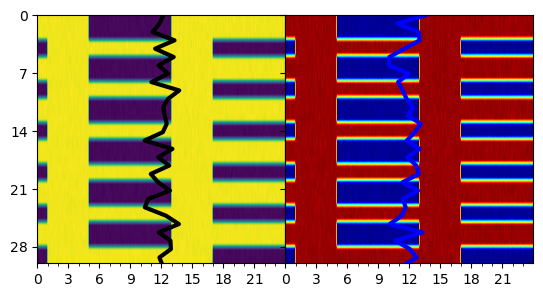

In [181]:
slam_shift = Light.ShiftWorkLight() 
ts = np.arange(0, 30*24.0, 0.10)
light_values = slam_shift(ts, repeat_period=24.0*5) + np.random.randn(len(ts)) * 1.0

fig, ax = plt.subplots(1,2, sharey='row')
act = plot_actogram(ax[0], zeitgeber=light_values, cmap='viridis')
act = plot_actogram(ax[1], zeitgeber=light_values)
ax[0].plot(120*np.ones(100)+10.0*np.random.randn(100), np.linspace(0,100,100), color='black', lw=3.0)
ax[1].plot(120*np.ones(100)+10.0*np.random.randn(100), 
           np.linspace(0,100,100), color='blue', lw=3.0)
fig.subplots_adjust(wspace=0, hspace=0)


In [182]:

def plot_phasetimes(ax: plt.Axes,
                    times: np.ndarray, 
                    phases: np.ndarray, 
                    error: np.ndarray = None,
                    alpha_error=0.30, 
                    alpha=1.0, 
                    *args, 
                    **kwargs):
    """
        This method takes observations of the phase and times (same length arrays)
        and adds them to the actogram.    

        plot_phasetimes(self, times: np.ndarray, phases: np.ndarray, *args, **kwargs)
    """
    xvals = deepcopy(phases)
    xvals = np.arctan2(np.sin(xvals), np.cos(xvals))
    for i in range(len(xvals)):
        if xvals[i] < 0.0:
            xvals[i] += 2*np.pi

    xvals = np.fmod(xvals, 2*np.pi)
    xvals *= 12.0/np.pi

    xvals = np.fmod(xvals, 24.0)
    yvals = deepcopy(times)
    yvals = np.floor(yvals / 24.0) + 0.5

    idx_split = (np.absolute(np.diff(xvals)) > 6.0).nonzero()[0]+1
    xvals_split = np.split(xvals, idx_split)
    yvals_split = np.split(yvals, idx_split)
    if error is not None:
        error_split = np.split(error, idx_split)

    for (idx, xx) in enumerate(xvals_split):
        ax.plot(xx, yvals_split[idx], alpha=alpha, *args, **kwargs)
        ax.plot(
            xx+24.0, yvals_split[idx], alpha=alpha, *args, **kwargs)
        if error is not None:
            ax.fill_betweenx(
                yvals_split[idx], xx-error_split[idx], xx+error_split[idx], alpha=alpha_error, *args, **kwargs)
            ax.fill_betweenx(
                yvals_split[idx], xx-error_split[idx]+24.0, xx+error_split[idx]+24.0, alpha=alpha_error, *args, **kwargs)
            
    return ax 

Text(0.5, 0, 'ZT')

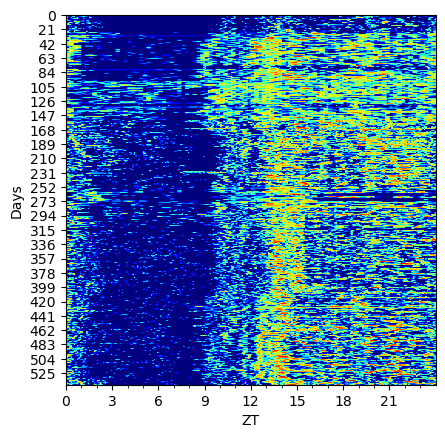

In [186]:
import circadian
from circadian.readers import read_standard_json
cpath = circadian.__path__[0]
wdata = read_standard_json(cpath + '/sample_data/sample_data.json')
fig, ax = plt.subplots(1,1, sharey='row')
plot_actogram(ax, zeitgeber=np.log(wdata.steps+1.0), cmap='jet', label_days=21)
ax.set_ylabel('Days')
ax.set_xlabel("ZT")
# -6.0 is to shift the time to the correct timezone from the UTC timezone of the data


In [15]:
# | hide
import nbdev
nbdev.nbdev_export()
